1. input is gray scale img, sigma of gaussian filter and 2 low and high thresholds
2. output is binary image
3. Implement gaussian convolution as a separable sequence of horizontal and vertical convolutions. 

In [1]:
from scipy import misc
import imageio
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2 

In [2]:
def get_kernel(dimension, standard_dev):
  kernel = np.linspace(-(dimension//2), dimension//2, dimension)
  index = 0
  while index < dimension:
    kernel[index] = (1 / np.sqrt( 2 * np.pi * (standard_dev * standard_dev) ) ) * np.exp(-( (kernel[index] * kernel[index])/(2*standard_dev*standard_dev) ) ) 
    index = index + 1
  #kernel = np.outer(kernel.T, kernel.T) 
  kernel = kernel/kernel.max()
  return kernel

print(get_kernel(5,2))

[0.60653066 0.8824969  1.         0.8824969  0.60653066]


G(x,y)*I=G(x)*(G(y)*I);

In [3]:
def horizontal_convolution(image, kernel):
  return vertical_convolution(image.T, kernel).T

In [4]:
def vertical_convolution(image, kernel):

  sum = np.sum(kernel)
  out = np.zeros(image.shape)

  pad = np.zeros((1,image.shape[1]))
  pad_image = np.vstack((pad, image))
  pad_image = np.vstack((pad_image, pad))
  for i in range(len(kernel)//2 -1):
    #print(i)
    pad_image = np.vstack((pad, pad_image))
    pad_image = np.vstack((pad_image, pad))


  # going down a row 
  # fix a column
  for c in range(image.shape[1]):
    # loop thru row
    for r in range(image.shape[0]):
      pixel_val = []
      for k in range(len(kernel)):
        #print(f"c:{c} r:{r} k:{k} pad_image[{r+k}][{c}] {pad_image[r+k][c]}")
        pixel_val.append(pad_image[r+k][c])
      #print('\n')
      pixel_val = np.multiply(pixel_val, kernel)
      pixel_val /= sum
      out[r][c] = np.sum(pixel_val)
  return out

In [5]:
def conv(image, kernel):
  row_out = vertical_convolution(image, kernel)
  conv = horizontal_convolution(row_out.T, kernel)
  return conv

In [45]:
def sobel(image):
  sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
  ##
  # Calculate derivative for sobel filter x
  dx = np.zeros(image.shape)
  

  image_padded_1 = np.zeros((image.shape[0] + (sobel_x.shape[0]//2)*2, image.shape[1] + (sobel_x.shape[1]//2)*2))

  image_padded_1[(sobel_x.shape[1]//2):image_padded_1.shape[0] - (sobel_x.shape[1]//2), (sobel_x.shape[0]//2): image_padded_1.shape[1] - (sobel_x.shape[0]//2)] = image

  # iterate over row indices of image
  for i in range(image.shape[0]):
    # iterate over col indices of image
      for j in range(image.shape[1]):
          stride_x = i + sobel_x.shape[0]
          stride_y = j + sobel_x.shape[1]
          stride = image_padded_1[i:stride_x, j:stride_y]
          dx[i,j]= np.sum(sobel_x * stride) 
  ##
  ### Calculate derivative for sobel filter y
  dy = np.zeros(image.shape)
  

  image_padded_2 = np.zeros((image.shape[0] + (sobel_y.shape[0]//2)*2, image.shape[1] + (sobel_y.shape[1]//2)*2))

  image_padded_2[sobel_y.shape[1]//2:image_padded_2.shape[0] - sobel_y.shape[1]//2, sobel_y.shape[0]//2: image_padded_2.shape[1] - sobel_y.shape[0]//2] = image

  # iterate over row indices of image
  for i in range(image.shape[0]):
    # iterate over col indices of image
      for j in range(image.shape[1]):
          stride_x = i + sobel_y.shape[0]
          stride_y = j + sobel_y.shape[1]
          stride = image_padded_2[i:stride_x, j:stride_y]
          dy[i,j]= np.sum(sobel_y * stride) 
  ##
  return (dx,dy)
def sobel_(imm):
  gaus = np.array([1,2,1])
  gx = np.array([-1,0,1])
  gy = np.array([1,0,-1])
  grad_y = conv(imm,gy, gaus)
  grad_x = conv(imm, gaus, gx)
  return grad_x, grad_y

In [7]:
def get_magnitude_direction(dx,dy):
  magnitude = np.hypot(dx,dy)
  magnitude = (magnitude/magnitude.max()) *255
  direction = np.arctan2(dx,dy) 
  return (magnitude, direction)

In [8]:
def non_maximum_suppression(magnitude, direction):
  row_indices = magnitude.shape[0] - 1
  col_indices = magnitude.shape[1] - 1
  edge_start = 0
  edge_end = 0
  pixels = np.zeros(magnitude.shape)
  degrees = direction
  degrees[degrees<0]+=180


  for row_index in range(1, row_indices):
    for col_index in range(1, col_indices):
      degree = degrees[row_index, col_index]
      

      #  22.5 <= angle < 67.5 degrees
      if(22.5 <= degree < 67.5):
        edge_start = magnitude[row_index + 1, col_index - 1]
        edge_end = magnitude[row_index - 1, col_index + 1]
      # 67.5 <= angle < 112.5 degrees
      elif(67.5 <= degree < 112.5):
        edge_start = magnitude[row_index + 1, col_index]
        edge_end = magnitude[row_index - 1, col_index]
      # 112.5 <= angle < 157.5 degrees
      elif(112.5 <= degree < 157.5):
        edge_start = magnitude[row_index - 1, col_index - 1]
        edge_end = magnitude[row_index + 1, col_index + 1]
      else:
        edge_start = magnitude[row_index, col_index - 1]
        edge_end = magnitude[row_index, col_index + 1]

      # suppress non maximum pixel values
      pixel = magnitude[row_index, col_index]
      if (pixel >= edge_start) and (pixel >= edge_end):
        pixels[row_index, col_index] = pixel
  return pixels

In [9]:
def double_threshold(pixels, low_threshold, high_threshold):
  strong = 255
  weak = 100


  threshold = np.zeros(pixels.shape)
  for i in range(pixels.shape[0]):
    for j in range(pixels.shape[1]):
      val = pixels[i,j]
      if val > high_threshold:
        threshold[i,j] = strong
      if (val > low_threshold) and (val < high_threshold):
        threshold[i,j] = weak

  return threshold
      
        
          

In [10]:
def hysterisis_thresholding(th):
  
  strong = 255
  weak = 100
  print("hist")

 
  r,c = th.shape
  for i in range(1,r-1):
    for j in range(1,c-1):
      val = th[i,j]
            
      if val == weak:
         # top or bottom neighbors
        if ((th[i+1,j] == strong) or (th[i-1,j] == strong)):
          th[i,j] = strong 
        # right or left neighbors
        elif ((th[i,j+1] == strong) or (th[i,j-1] == strong)):
          th[i,j] = strong 
        # top diagonal neighbors
        elif ((th[i+1,j-1] == strong) or (th[i+1,j+1] == strong)):
          th[i,j] = strong 
        # bottom diagonal neighbors
        elif ((th[i-1,j-1] == strong) or (th[i-1,j+1] == strong)):
          th[i,j] = strong
        else:
          th[i,j] = 0

  return th


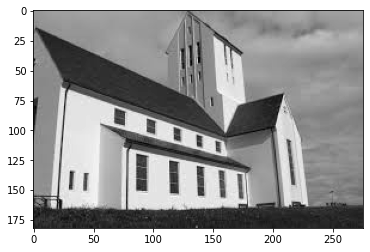

[0.8007374  0.94595947 1.         0.94595947 0.8007374 ]

shape(5,)

[[0.64118039 0.75746513 0.8007374  0.75746513 0.64118039]
 [0.75746513 0.89483932 0.94595947 0.89483932 0.75746513]
 [0.8007374  0.94595947 1.         0.94595947 0.8007374 ]
 [0.75746513 0.89483932 0.94595947 0.89483932 0.75746513]
 [0.64118039 0.75746513 0.8007374  0.75746513 0.64118039]]
[0.8007374  0.94595947 1.         0.94595947 0.8007374 ]
5


In [12]:
image = cv2.imread("image1.jfif")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

plt.imshow(image, cmap = plt.get_cmap('gray'))
plt.show()
kernel= get_kernel(5,3)
print(kernel)
norm = kernel/kernel.max()
print(f"\nshape{norm.shape}\n")
out = np.outer(norm, norm.T)
print(out)
print(kernel/kernel.max())
print(len(norm))

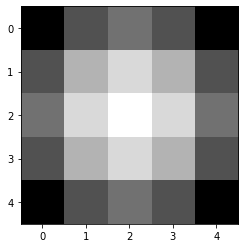

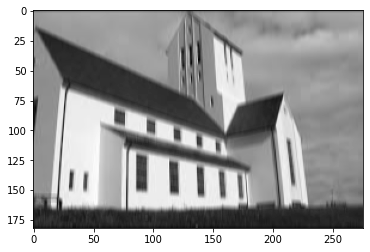

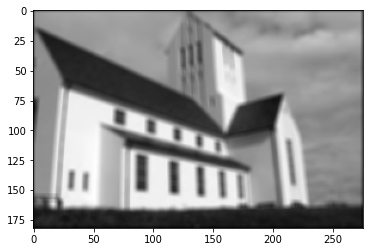

In [35]:
kernel= get_kernel(5,3)

kernel_outer_prod = np.outer(kernel, kernel.T)
plt.imshow(kernel_outer_prod, cmap="gray")
plt.show()

v1 = vertical_convolution(image, kernel_outer_prod)
plt.title("Gradient Direction Horizontal")
plt.imshow(v1, cmap="gray")
plt.show()

h1 = horizontal_convolution(v1, kernel)
plt.imshow(h1, cmap="gray")
plt.show()

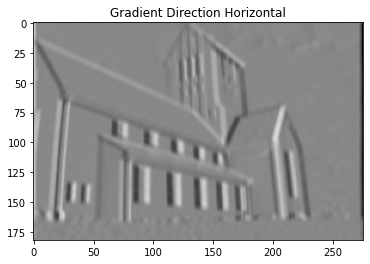

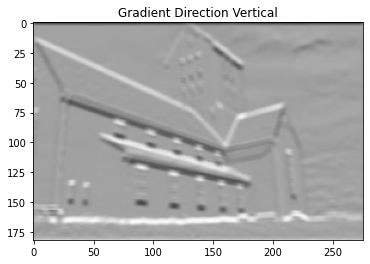

In [36]:
dx,dy = sobel(h1)

plt.imshow(dx, cmap="gray")
plt.title("Gradient Direction Horizontal")
plt.show()

plt.imshow(dy, cmap="gray")
plt.title("Gradient Direction Vertical")
plt.show()


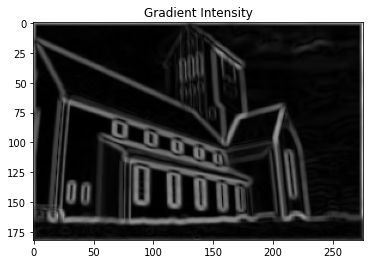

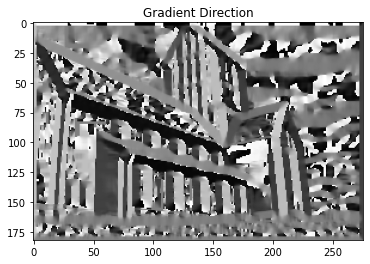

In [42]:
gradient_magnitude, gradient_direction = get_magnitude_direction(dx,dy)


plt.imshow(gradient_magnitude, cmap="gray")
plt.title("Gradient Intensity")
plt.show()


plt.imshow(gradient_direction, cmap="gray")
plt.title("Gradient Direction")
plt.show()


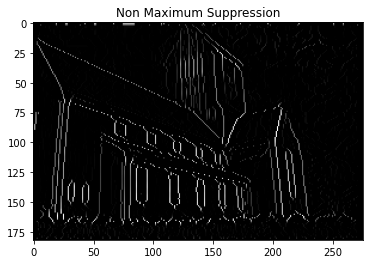

In [38]:

non_max_sup = non_maximum_suppression(gradient_magnitude, gradient_direction)

plt.imshow(non_max_sup, cmap="gray")
plt.title("Non Maximum Suppression")
plt.show()

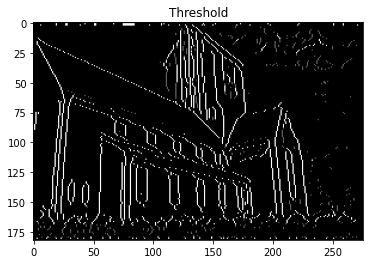

In [39]:
threshold = double_threshold(non_max_sup, 10, 20)

plt.imshow(threshold, cmap="gray")
plt.title("Threshold")
plt.show()

hist


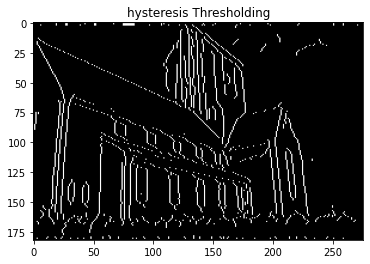

In [40]:
hys = hysterisis_thresholding(threshold)
plt.imshow(hys, cmap="gray")
plt.title("hysteresis Thresholding")
plt.show()

In [54]:
def start(size=5,image="image1.jfif", sigma=5, low_threshold=4, high_threshold=20):
  image = cv2.imread(image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

  plt.imshow(image, cmap = plt.get_cmap('gray'))
  plt.show()

  kernel = get_kernel(size,sigma)
  kernel_outer_prod = np.outer(kernel, kernel.T)

  plt.title(f"Kernel sigma = {sigma} size = {size}")
  plt.imshow(kernel_outer_prod, cmap="gray")
  plt.show()

  v1 = vertical_convolution(image, kernel)
  plt.title("Gaussian Blur Vertical")
  plt.imshow(v1, cmap="gray")
  plt.show()

  h1 = horizontal_convolution(v1, kernel)
  plt.title("Gaussian Blur Horizontal")
  plt.imshow(h1, cmap="gray")
  plt.show()

  dx,dy = sobel(h1)

  plt.imshow(dx, cmap="gray")
  plt.title("Gradient Direction Horizontal")
  plt.show()

  plt.imshow(dy, cmap="gray")
  plt.title("Gradient Direction Vertical")
  plt.show()

  gradient_magnitude, gradient_direction = get_magnitude_direction(dx,dy)


  plt.imshow(gradient_magnitude, cmap="gray")
  plt.title("Gradient Magnitude (Intensity)")
  plt.show()


  plt.imshow(gradient_direction, cmap="gray")
  plt.title("Gradient Direction")
  plt.show()



  non_max_sup = non_maximum_suppression(gradient_magnitude, gradient_direction)

  plt.imshow(non_max_sup, cmap="gray")
  plt.title("Non Maximum Suppression")
  plt.show()


  threshold = double_threshold(non_max_sup, low_threshold, high_threshold)

  plt.imshow(threshold, cmap="gray")
  plt.title(f"Low Threshold = {low_threshold} High Threshold = {high_threshold}")
  plt.show()


  hys = hysterisis_thresholding(threshold)
  plt.imshow(hys, cmap="gray")
  plt.title(f"hysteresis Thresholding")
  plt.show()

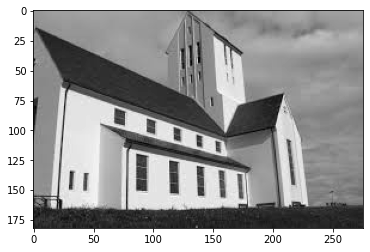

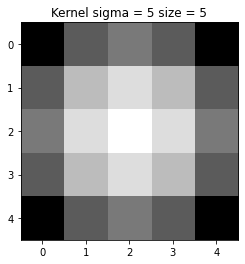

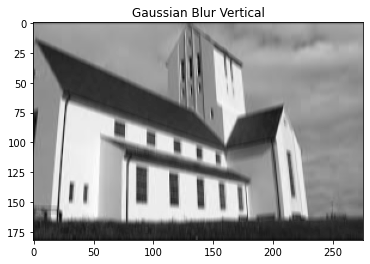

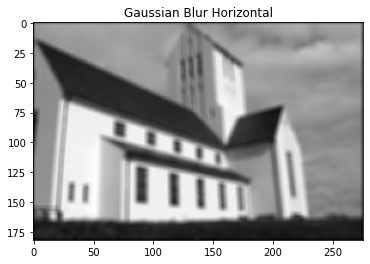

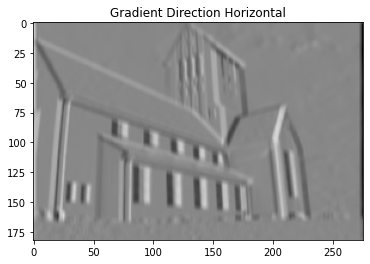

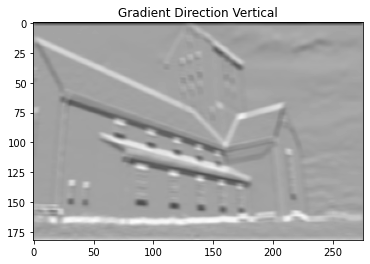

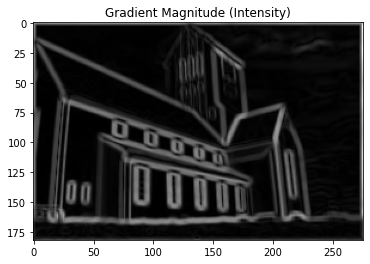

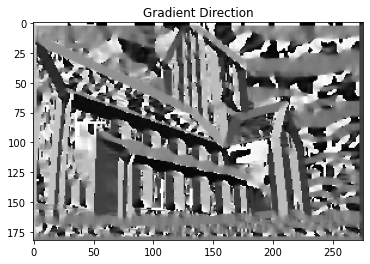

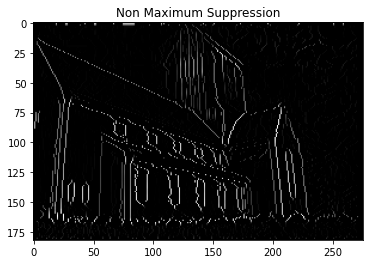

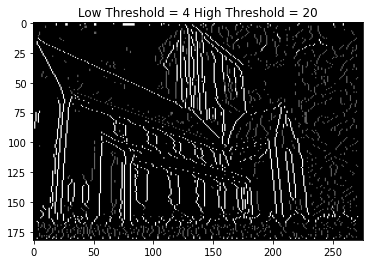

hist


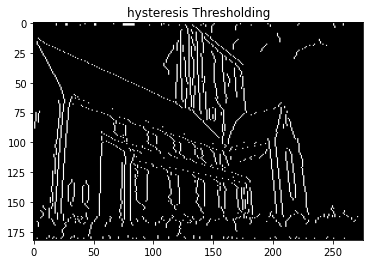

In [55]:
start()